In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import anndata as ad
import scipy
from tqdm import tqdm
import anndata
import random
from sklearn.metrics import adjusted_rand_score
from scipy.sparse import hstack
# sc.settings.set_figure_params(dpi=400, transparent=True, format = 'eps')
random.seed(0)

In [2]:
X_new = sc.read_mtx('filtered_peak_bc_matrix/matrix.mtx')
var_tmp = pd.read_csv('filtered_peak_bc_matrix/peaks.bed',header = None)
var_tmp.columns = ['features']
obs = pd.read_csv('filtered_peak_bc_matrix/barcodes.tsv',header = None)
obs[0] = obs[0].apply(lambda x : x[:-2])
obs['cell_barcodes'] = obs[0]
obs = obs.set_index(0)
adata_full = sc.read_h5ad('mouse_brain.h5ad')
meta = adata_full.obs[['predicted.id']]
meta['cell_barcodes'] = meta.index
meta.cell_barcodes = meta.cell_barcodes.apply(lambda x: x[:-2])

C:\Users\roxan\AppData\Local\Temp\ipykernel_37512\842781071.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['cell_barcodes'] = meta.index
C:\Users\roxan\AppData\Local\Temp\ipykernel_37512\842781071.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.cell_barcodes = meta.cell_barcodes.apply(lambda x: x[:-2])


In [3]:
TEs = pd.read_csv('TE_MTX.csv', index_col = 0)
TEs = TEs[obs.cell_barcodes.tolist()]
TEs_mtx = scipy.sparse.csr_matrix(TEs.values)
full_mtx = hstack([X_new.X.T, TEs_mtx.T],format ='csr')

In [4]:
obs = obs.merge(meta, on = 'cell_barcodes', how = 'left')
obs.index = obs['cell_barcodes']
obs.index.name='CB'
TE_var = TEs
TE_var['features'] = TE_var.index
TE_var=TE_var[['features']]
var = pd.concat([var_tmp,TE_var])
var.index = var.features
X = full_mtx
adata_full = anndata.AnnData(X, obs=obs, var=var, dtype='int32')

In [5]:
adata_full

AnnData object with n_obs × n_vars = 5337 × 168710
    obs: 'cell_barcodes', 'predicted.id'
    var: 'features'

C:\Users\roxan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


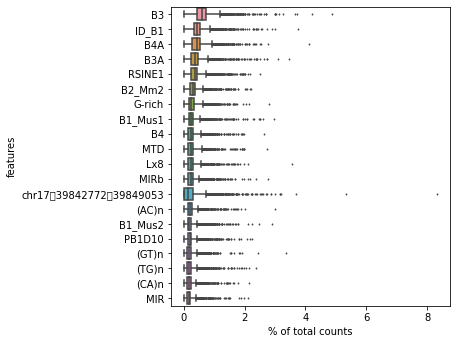

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\roxan\anaconda3\lib\contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


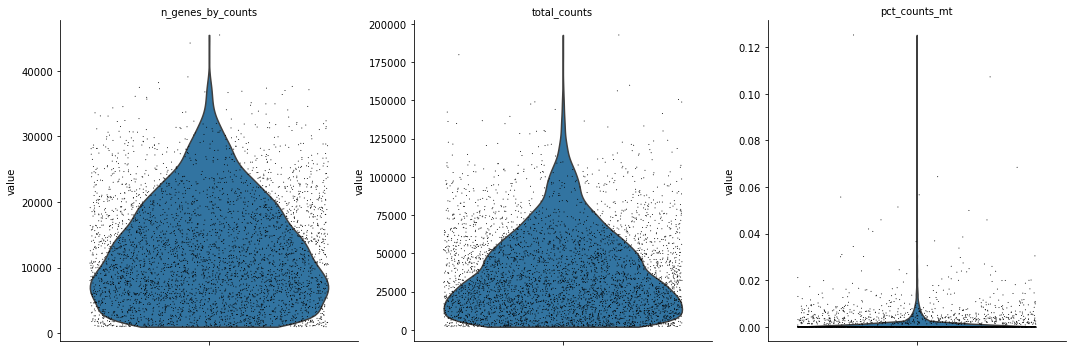

In [6]:
sc.pl.highest_expr_genes(adata_full, n_top=20, )
sc.pp.filter_cells(adata_full, min_genes=1000)
sc.pp.filter_genes(adata_full, min_cells=10)
adata_full.var['mt'] = adata_full.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_full = adata_full[adata_full.obs.pct_counts_mt < 20, :]
sc.pl.violin(adata_full, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

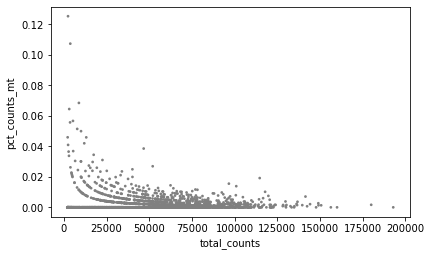

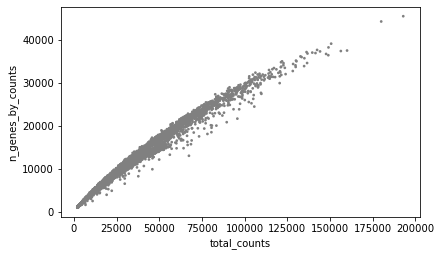

In [7]:
sc.pl.scatter(adata_full, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_full, x='total_counts', y='n_genes_by_counts')

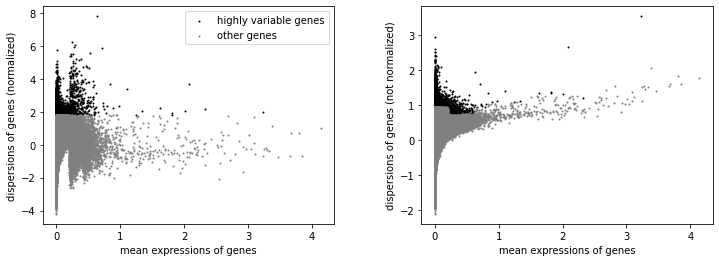

In [8]:
sc.pp.normalize_total(adata_full, target_sum=1e4)
sc.pp.log1p(adata_full)
sc.pp.highly_variable_genes(adata_full, n_top_genes=4000)
sc.pl.highly_variable_genes(adata_full)

In [9]:
adata_full.raw = adata_full
adata_full = adata_full[:, adata_full.var.highly_variable]
sc.pp.regress_out(adata_full, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_full, max_value=10)

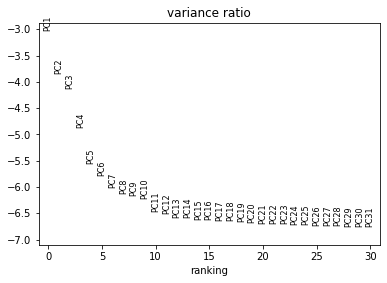

In [10]:
sc.tl.pca(adata_full, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_full, log=True)

In [11]:
from sklearn.metrics import adjusted_rand_score
ari = []
random.seed(12)
randomlist = random.sample(range(0, 50), 15)
sc.pp.neighbors(adata_full, n_neighbors=20, n_pcs=40)
for i in randomlist:
    sc.tl.leiden(adata_full,random_state = i)
    sc.tl.paga(adata_full)
    sc.pl.paga(adata_full, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(adata_full, init_pos='paga')
    predict = adata_full.obs.leiden.tolist()
    true = adata_full.obs['predicted.id'].tolist()
    ari.append(adjusted_rand_score(predict, true))

In [12]:
np.mean(ari)

0.5613401280389654

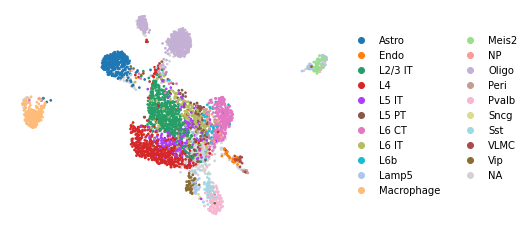

In [13]:
sc.pp.neighbors(adata_full, n_neighbors=20, n_pcs=40)
sc.tl.leiden(adata_full,random_state = 49)
sc.tl.paga(adata_full)
sc.pl.paga(adata_full, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_full, init_pos='paga')
sc.pl.umap(adata_full, color=['predicted.id'],title = '',frameon = False,save='_mouse_brain_full')

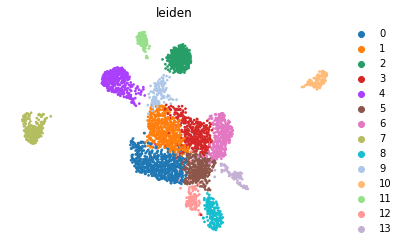

In [14]:
sc.pp.neighbors(adata_full, n_neighbors=20, n_pcs=40)
sc.tl.leiden(adata_full,random_state = 49)
sc.tl.paga(adata_full)
sc.pl.paga(adata_full, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_full, init_pos='paga')
sc.pl.umap(adata_full, color='leiden', legend_fontsize =10, frameon = False,save='_full_leiden')

In [15]:
TEs = pd.read_csv('TE_MTX.csv',index_col = 0)
TEs = TEs[meta.cell_barcodes.tolist()]
TEs_mtx = scipy.sparse.csr_matrix(TEs.values)
obs = meta
obs.index.name='CB'
obs.index = obs['cell_barcodes']
TE_var = TEs
TE_var['features'] = TE_var.index
TE_var=TE_var[['features']]
var = TE_var
X = TEs_mtx.T
adata_TE = anndata.AnnData(X, obs=obs, var=var, dtype='int32')

In [16]:
adata_TE

AnnData object with n_obs × n_vars = 3517 × 10913
    obs: 'predicted.id', 'cell_barcodes'
    var: 'features'

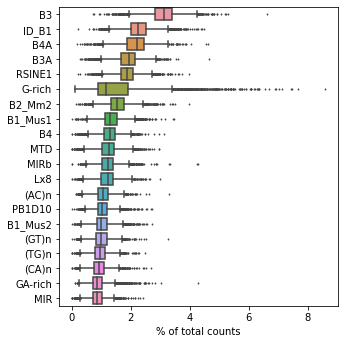

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\roxan\anaconda3\lib\contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


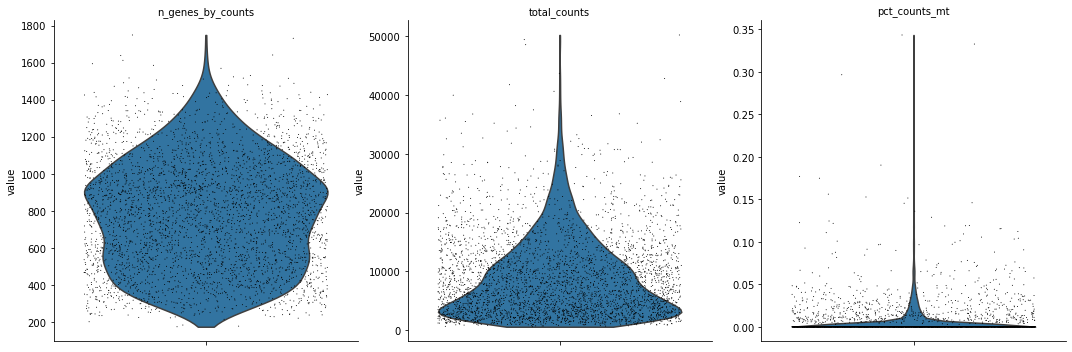

In [17]:
sc.pl.highest_expr_genes(adata_TE, n_top=20, )
adata_TE.var['mt'] = adata_TE.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_TE, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_TE = adata_TE[adata_TE.obs.pct_counts_mt < 20, :]
sc.pl.violin(adata_TE, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

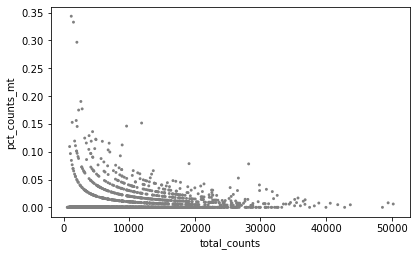

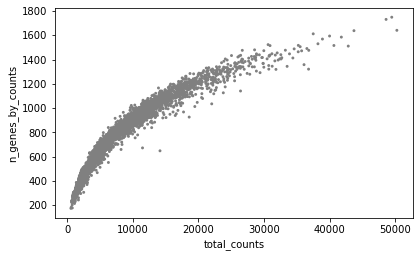

In [18]:
sc.pl.scatter(adata_TE, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_TE, x='total_counts', y='n_genes_by_counts')

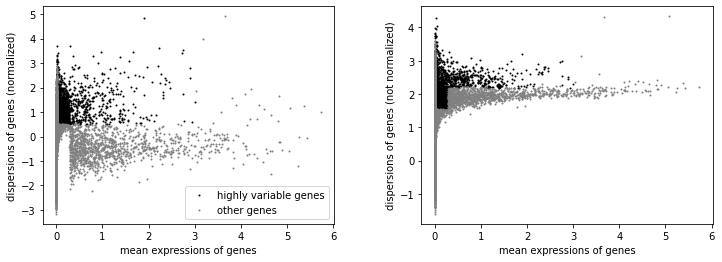

In [19]:
sc.pp.normalize_total(adata_TE, target_sum=1e4)
sc.pp.log1p(adata_TE)
sc.pp.highly_variable_genes(adata_TE)
sc.pl.highly_variable_genes(adata_TE)

In [20]:
adata_TE.raw = adata_TE
adata_TE = adata_TE[:, adata_TE.var.highly_variable]
sc.pp.regress_out(adata_TE, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_TE, max_value=10)

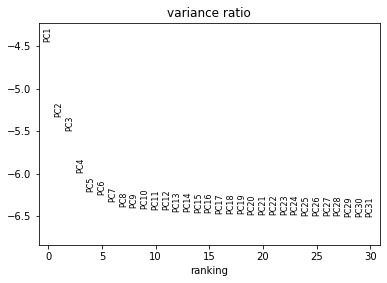

In [21]:
sc.tl.pca(adata_TE, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_TE, log=True)

In [22]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
ari = []
random.seed(12)
randomlist = random.sample(range(0, 50), 15)
sc.pp.neighbors(adata_TE, n_neighbors=20, n_pcs=40)
for i in randomlist:
    sc.tl.leiden(adata_TE, random_state = i)
    sc.tl.paga(adata_TE)
    sc.pl.paga(adata_TE, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(adata_TE, init_pos='paga')
    predict = adata_TE.obs.leiden.tolist()
    true = adata_TE.obs['predicted.id'].tolist()
    ari.append(adjusted_rand_score(predict, true))

In [23]:
np.mean(ari)

0.320281807331278

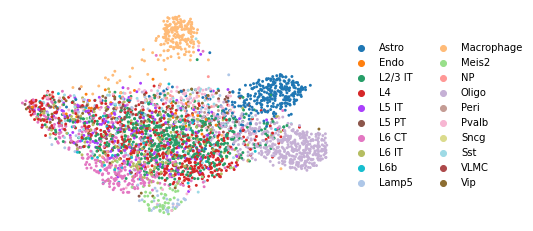

In [24]:
random.seed(12)
randomlist = random.sample(range(0, 50), 15)
sc.pp.neighbors(adata_TE, n_neighbors=45, n_pcs=40)
sc.tl.leiden(adata_TE, random_state = randomlist[9])
sc.tl.paga(adata_TE)
sc.pl.paga(adata_TE, plot=False)
sc.tl.umap(adata_TE, init_pos='paga')
sc.pl.umap(adata_TE, color=['predicted.id'], title = '', frameon = False, save = 'TECluster')

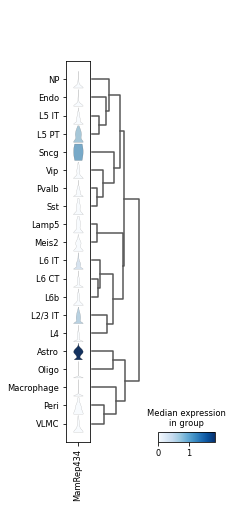

In [25]:
sc.pl.stacked_violin(adata_TE, 'MamRep434', groupby='predicted.id', dendrogram=True)

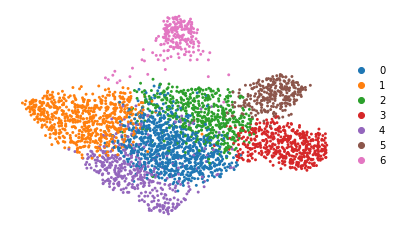

In [26]:
random.seed(12)
randomlist = random.sample(range(0, 50), 15)
sc.pp.neighbors(adata_TE, n_neighbors=45, n_pcs=40)
sc.tl.leiden(adata_TE, random_state = randomlist[9])
sc.tl.paga(adata_TE)
sc.pl.paga(adata_TE, plot=False)
sc.tl.umap(adata_TE, init_pos='paga')
sc.pl.umap(adata_TE, color='leiden',title = '', frameon = False,save='_TE_leiden')

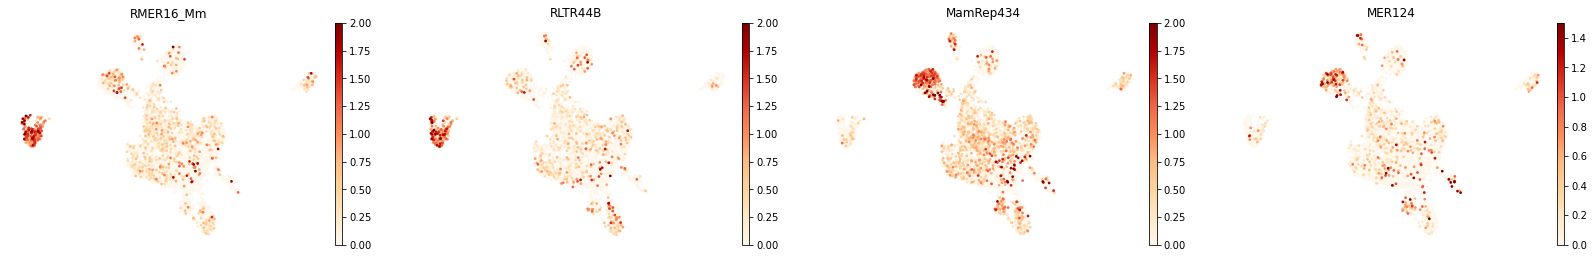

In [27]:
sc.pl.umap(adata_full, color=['RMER16_Mm','RLTR44B','MamRep434','MER124'], color_map = 'OrRd',vmax = [2,2,2,1.5], frameon = False, save = 'Marker_Gene')

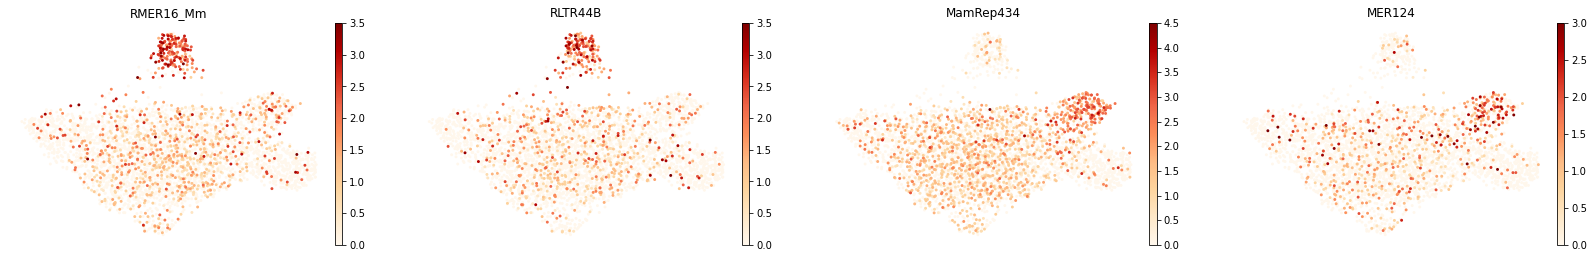

In [29]:
sc.pl.umap(adata_TE, color=['RMER16_Mm','RLTR44B','MamRep434','MER124'], color_map = 'OrRd' ,vmax = [3.5,3.5,4.5,3], frameon = False)

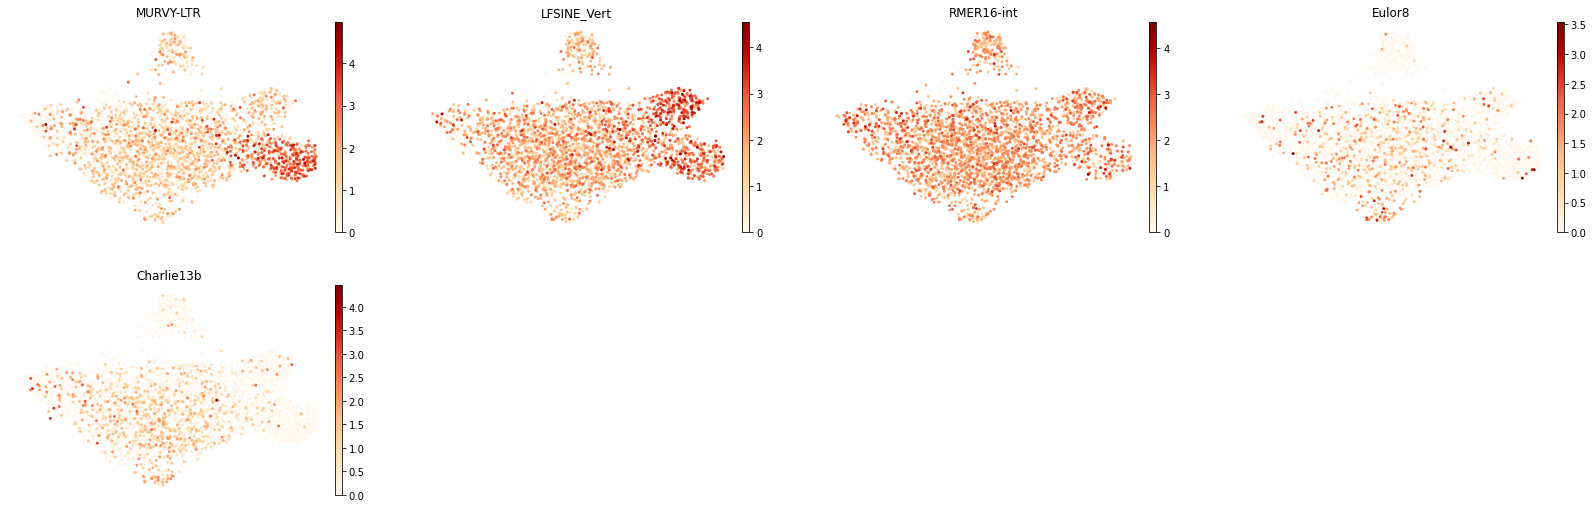

In [30]:
sc.pl.umap(adata_TE, color=['MURVY-LTR','LFSINE_Vert','RMER16-int','Eulor8', 'Charlie13b'], color_map = 'OrRd',  frameon = False)

In [31]:
adata_tmp = adata_TE
tmp_var = adata_tmp.var.reset_index(drop = True)
tmp_var = tmp_var[~tmp_var['features'].str.endswith((')n'))]
idx = tmp_var.index.tolist()
tmp_var.index = tmp_var['features']
tmp_X = adata_tmp.X[:, idx]
adata_tmp = anndata.AnnData(tmp_X, obs=adata_tmp.obs, var=tmp_var, dtype='int32')

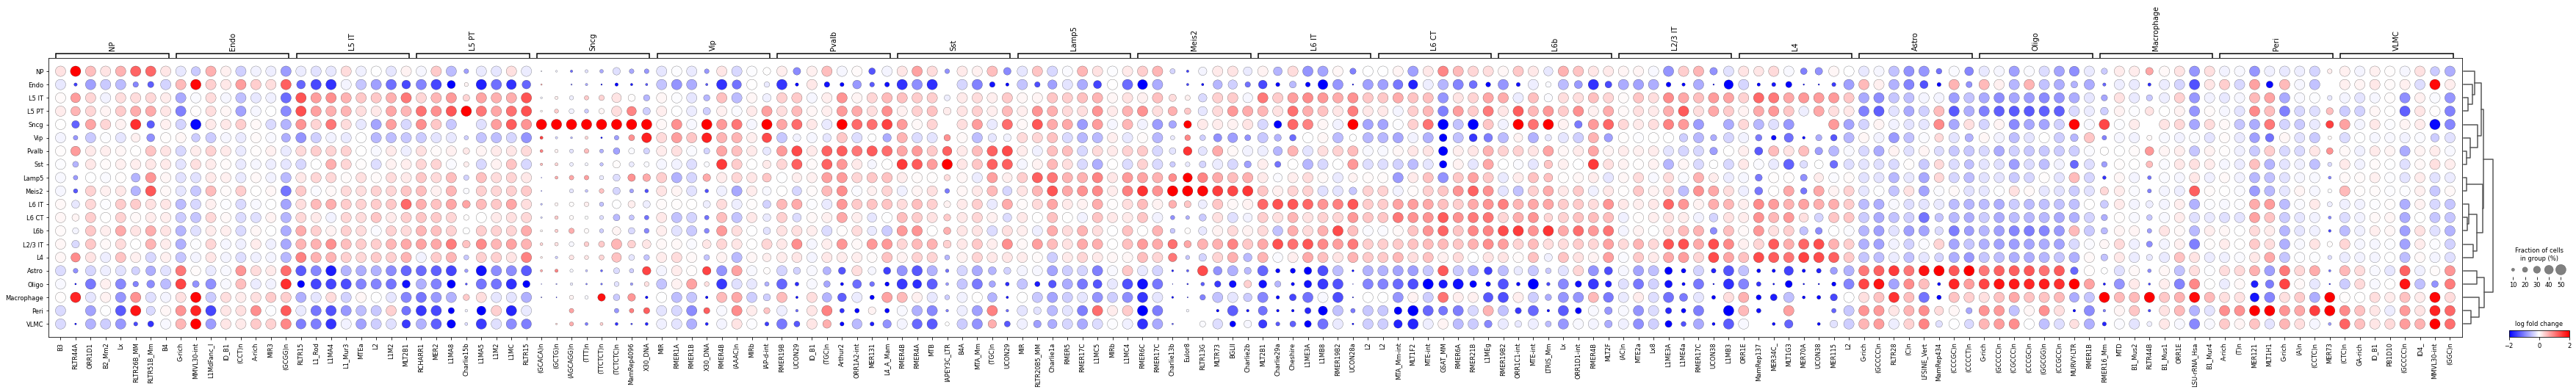

In [32]:
# sc.pp.scale(adata_tmp,max_value=10)
sc.tl.rank_genes_groups(adata_TE, groupby='predicted.id', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_TE, n_genes=8, values_to_plot='logfoldchanges', dot_max = 0.5, vmax=2, vmin=-2, cmap='bwr', save = 'dotplot_tmp1')

In [33]:
result = adata_TE.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes_dict = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names']})[0:30]

In [34]:
marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names']})[0:30]

In [35]:
marker_genes.columns = [col[:-2] for col in marker_genes.columns]

In [36]:
marker_genes

,Astro,Endo,L2/3 IT,L4,L5 IT,L5 PT,L6 CT,L6 IT,L6b,Lamp5,Macrophage,Meis2,NP,Oligo,Peri,Pvalb,Sncg,Sst,VLMC,Vip
0,G-rich,G-rich,(AC)n,ORR1E,RLTR15,RCHARR1,L2,MLT2B1,RMER19B2,MIR,RMER16_Mm,RMER6C,B3,G-rich,A-rich,RMER19B,(GCACA)n,RMER4B,(CTC)n,MIR
1,(GCCCC)n,MMVL30-int,MTE2a,MamRep137,L1_Rod,MER2,MTA_Mm-int,Charlie29a,ORR1C1-int,RLTR20B5_MM,MTD,RMER17C,RLTR44A,(GCCCC)n,(T)n,UCON29,(GCTG)n,RMER4A,GA-rich,RMER1A
2,RLTR28,L1MdFanc_I,Lx8,MER34C_,L1MA4,L1MA8,MLT1F2,Cheshire,MTE-int,Charlie1a,B1_Mus2,Charlie13b,ORR1D1,(CGCCC)n,MER121,ID_B1,(AGCAGG)n,MTB,ID_B1,RMER1B
3,(C)n,ID_B1,L1ME3A,MLT1G3,L1_Mur3,Charlie15b,MTE-int,L1ME3A,LTRIS_Mm,RMER5,RLTR44B,Eulor8,B2_Mm2,(CCCGC)n,MLT1H1,(TGC)n,(TTT)n,IAPEY3C_LTR,PB1D10,X30_DNA
4,LFSINE_Vert,(CCT)n,L1ME4a,MER70A,MTEa,L1MA5,GSAT_MM,L1MB8,Lx,RMER17C,B1_Mus1,RLTR13G,Lx,(GGCGG)n,G-rich,Arthur2,(TTCTCT)n,B4A,(GCCCC)n,RMER4B
5,MamRep434,A-rich,RMER17C,UCON38,L2,L1M2,RMER6A,RMER19B2,ORR1D1-int,L1MC5,ORR1E,MLTR73,RLTR26B_MM,(CCGCC)n,(A)n,ORR1A2-int,(TCTCTC)n,MTA_Mm,ID4_,(AAAC)n
6,(CCCGC)n,MIR3,UCON38,MER115,L1M2,L1MC,RMER21B,UCON28a,RMER4B,MIRb,LSU-rRNA_Hsa,BGLII,RLTR51B_Mm,MURVY-LTR,(CCTC)n,MER131,MamRep4096,(TGC)n,MMVL30-int,MIRb
7,(CCCCT)n,(GCGG)n,L1MB3,L2,MLT2B1,RLTR15,L1MEg,L2,MLT2F,L1MC4,B1_Mur4,Charlie2b,B4,RMER1B,MER73,L4_A_Mam,X30_DNA,UCON29,(GGC)n,IAP-d-int
8,(CGCCC)n,RLTR9A3,Charlie29a,RLTR20A2B_MM,MTEb,L1M5,MIRb,L1M5,GSAT_MM,L1M5,RLTR45,MamGypsy2-I,RMER17C,(CCG)n,GA-rich,MT2C_Mm,RLTR9E,Tigger1,A-rich,MLT1H
9,(CGCC)n,PB1D9,L1MB1,LTR16,MER94B,MARNA,RMER15,RMER19C,B4,Eulor8,RLTR28,RMER5,ORR1A0,(CCCCG)n,(TTTG)n,MTA_Mm,(AGAC)n,X7A_LINE,G-rich,Lx4B
